## Configuraciones previas
Para poder resolver los problemas planteados en el enunciado se deben realizar ciertos ajustes y preparaciones en el entorno de ejecución, como por ejemplo la llamada a las librerias de Python y la inclusión del dataset a trabajar.

Para una ejecución más veloz se recomienda habilitar el tipo de entorno enfocado en GPU en las configuraciones de Colab.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d jeffheaton/iris-computer-vision
! unzip /content/iris-computer-vision.zip

  0% 0.00/5.33M [00:00<?, ?B/s]
100% 5.33M/5.33M [00:00<00:00, 61.7MB/s]
Archive:  /content/iris-computer-vision.zip
  inflating: iris-setosa/iris-01ab65973fd487a6cee4c5af1551c42b264eec5abab46bffd7c307ffef647e11.jpg  
  inflating: iris-setosa/iris-0797945218a97d6e5251b4758a2ba1b418cbd52ce4ef46a3239e4b939bd9807b.jpg  
  inflating: iris-setosa/iris-0c826b6f4648edf507e0cafdab53712bb6fd1f04dab453cee8db774a728dd640.jpg  
  inflating: iris-setosa/iris-0ff5ba898a0ec179a25ca217af45374fdd06d606bb85fc29294291facad1776a.jpg  
  inflating: iris-setosa/iris-1289c57b571e8e98e4feb3e18a890130adc145b971b7e208a6ce5bad945b4a5a.jpg  
  inflating: iris-setosa/iris-16f7515e1d6aa6d7dd3af4bca38c8065bfab9d426c5fd75b3c4bc51d737fb9d0.jpg  
  inflating: iris-setosa/iris-1e80d2d6f3e9cf96c1cb33f3e47f3e5a3f4a6eb26fa3ab479d462e1ac837ba66.jpg  
  inflating: iris-setosa/iris-1f941001f508ff1bd492457a90da64e52c461bfd64587a3cf7c6bf1bcb35adab.jpg  
  inflating: iris-setosa/iris-20f5f654ae5fbcc405b465ce257c187f81eb5fc070531

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os

## Clasificación

In [55]:
batch_size = 10
img_height = 224
img_width = 224

Para lograr el correcto funcionamiento de la red neuronal se debe crear una carpeta de nombre iris que contenga a las carpetas iris-setosa, iris-versicolour y iris-virginica pertenecientes al dataset.

In [7]:
!mkdir iris
!mv iris-setosa/ iris/iris-setosa/ 
!mv iris-versicolour/ iris/iris-versicolour/
!mv iris-virginica/ iris/iris-virginica/ 

Se prepara el conjunto de datos de entrenamiento.

In [56]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/iris',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 421 files belonging to 3 classes.
Using 337 files for training.


Se prepara el conjunto de datos de validación.

In [57]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/content/iris',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 421 files belonging to 3 classes.
Using 84 files for validation.


In [10]:
class_names = training_ds.class_names

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Se definen las capas de la Red Neuronal Convolucional a usar para la clasificación de las imágenes.

In [59]:
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

In [61]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Se realiza el entrenamiento de la red.

In [62]:
retVal = MyCnn.fit(training_ds,validation_data= validation_ds,epochs = 5)

Epoch 1/5
34/34 [==============================] - 2s 45ms/step - loss: 1.6028 - accuracy: 0.6231 - val_loss: 1.4873 - val_accuracy: 0.6548
Epoch 2/5
34/34 [==============================] - 1s 28ms/step - loss: 0.9291 - accuracy: 0.6350 - val_loss: 1.0092 - val_accuracy: 0.6429
Epoch 3/5
34/34 [==============================] - 1s 27ms/step - loss: 0.8191 - accuracy: 0.6528 - val_loss: 1.0944 - val_accuracy: 0.6429
Epoch 4/5
34/34 [==============================] - 1s 27ms/step - loss: 0.7749 - accuracy: 0.6795 - val_loss: 1.0373 - val_accuracy: 0.6071
Epoch 5/5
34/34 [==============================] - 1s 28ms/step - loss: 0.6053 - accuracy: 0.7418 - val_loss: 1.1799 - val_accuracy: 0.6190


Se realizan los gráficos y la comparación de la etiqueta clasificada con la etiqueta real.

1/1 [==============================] - 0s 75ms/step


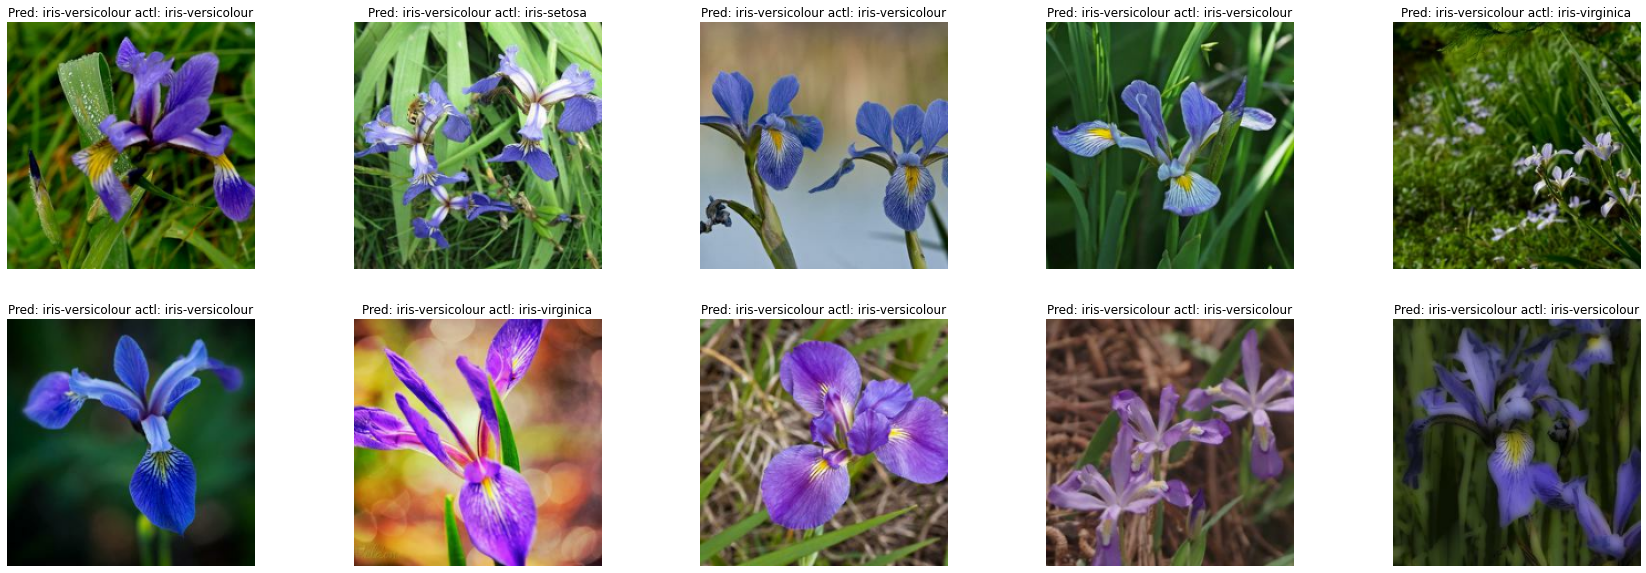

In [63]:
plt.figure(figsize=(30, 10))
for images, labels in validation_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl: '+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

Se realizan gráficos de la precisión y la perdida asociada al dataset y a la clasificación llevada a cabo, tanto para el caso de entrenamiento como para la validación.

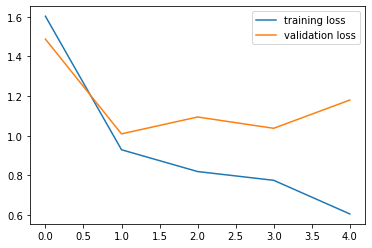

In [64]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.legend()

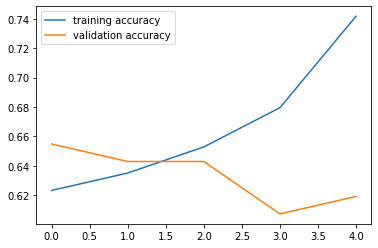

In [65]:
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

## Análisis
Como principales métricas de error se tienen la perdida tanto en el conjunto de entrenamiento como en el de validación, esto puede verse reflejado en su respectivo gráfico y representa lo "cerca" que se puede estar a caer en un estado de *overfitting* o *underfitting*. En cuanto a la evolución de la calidad de la red, esta puede verse reflejada en la tendencia al aumento de la métrica de precisión para ambas secciones del dataset. Si se analizan los hiper-parámetros de inicio utilizados se tiene que la cantidad de iteraciones (*epochs*) a realizar no debe superar las 5 ya que en caso contrario segun el modelo planteado se llega a un estado de *overfitting*. De manera similar se puede analizar la cantidad de fotos a mostrar como resultado parcial de la ejecución, dicho valor (*batch_size*) es inicializado en 10 para ahorrar recursos de procesamiento gráfico y enfocar su uso en la tarea de clasificación.

## Predicción

Para la realización de esta sección de la tarea se debe trabajar con otro dataset, el cual incluye datos sobre el sépalo y el pétalo de las flores, además de su respectiva foto. Dicho dataset es el resultante de la mezcla manual de los ya publicados en kaggle.

In [18]:
! kaggle datasets download -d uciml/iris
! unzip /content/iris.zip

  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 3.71MB/s]
Archive:  /content/iris.zip
  inflating: Iris.csv                
  inflating: database.sqlite         


In [19]:
!pip install -U pandasql 
from pandasql import sqldf
from os import listdir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=68f87022a6aabc60121fda8aade7948d50a67e3f1c84b5ad6feef3e6cbacbb43
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [20]:
data = pd.read_csv("Iris.csv")

In [21]:
cont = 0
cont2 = 0
cont3 = 0
folder_dir = "iris/iris-setosa"
folder_dir2 = "iris/iris-versicolour"
folder_dir3 = "iris/iris-virginica"
path_list = []

for images in os.listdir(folder_dir):
  while cont < 50:
    if (images.endswith(".jpg")):
        path = folder_dir + "/" + images
        path_list.append(path)
        cont += 1

for images in os.listdir(folder_dir2):
  while cont2 < 50:
    if (images.endswith(".jpg")):
        path2 = folder_dir2 + "/" + images
        path_list.append(path2)
        cont2 += 1

for images in os.listdir(folder_dir3):
  while cont3 < 50:
    if (images.endswith(".jpg")):
        path3 = folder_dir3 + "/" + images
        path_list.append(path3)
        cont3 += 1

data['Path'] = path_list
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Path
0,1,5.1,3.5,1.4,0.2,Iris-setosa,iris/iris-setosa/iris-332953f4d6a355ca189e2508...
1,2,4.9,3.0,1.4,0.2,Iris-setosa,iris/iris-setosa/iris-332953f4d6a355ca189e2508...
2,3,4.7,3.2,1.3,0.2,Iris-setosa,iris/iris-setosa/iris-332953f4d6a355ca189e2508...
3,4,4.6,3.1,1.5,0.2,Iris-setosa,iris/iris-setosa/iris-332953f4d6a355ca189e2508...
4,5,5.0,3.6,1.4,0.2,Iris-setosa,iris/iris-setosa/iris-332953f4d6a355ca189e2508...


Se realiza la separación del dataset en las secciones de training y testing.

In [38]:
q="SELECT *, Id%10 as grup FROM data WHERE grup = 0 OR grup= 1 OR grup = 2 OR grup = 3 OR grup = 7 OR grup = 8 OR grup = 9 OR grup= 4 OR grup= 5  "
TrainingData = sqldf(q,globals())

q="SELECT *, Id%10 as grup FROM data WHERE grup= 6  "
TestingData = sqldf(q,globals())

print(TrainingData.shape)
print(TestingData.shape)

(135, 8)
(15, 8)


Luego de crear y preparar el dataset se incluyen las librerias necesarias para la resolución del problema planteado.

In [39]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

Se generan las configuraciones necesarias para el funcionamiento de la Red Neuronal Convolucional.

In [45]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.223
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [46]:
train_images = train_generator.flow_from_dataframe(
    dataframe=TrainingData,
    x_col='Path',
    y_col=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm'],
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=TrainingData,
    x_col='Path',
    y_col=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm'],
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=TestingData,
    x_col='Path',
    y_col=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm'],
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 105 validated image filenames.
Found 30 validated image filenames.
Found 15 validated image filenames.


Se genera la estructura de capas de la red a usar para la predicción de parámetros.

In [69]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
4/4 [==============================] - 1s 110ms/step - loss: 16.6382 - accuracy: 1.0000 - val_loss: 8.6190 - val_accuracy: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 57ms/step - loss: 15.1499 - accuracy: 1.0000 - val_loss: 7.2094 - val_accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 71ms/step - loss: 12.7311 - accuracy: 1.0000 - val_loss: 5.2049 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 109ms/step - loss: 9.9992 - accuracy: 1.0000 - val_loss: 2.7678 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 1s 170ms/step - loss: 5.2526 - accuracy: 1.0000 - val_loss: 1.3086 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 62ms/step - loss: 2.2460 - accuracy: 1.0000 - val_loss: 3.9370 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 72ms/step - loss: 2.2375 - accuracy: 1.0000 - val_loss: 7.7305 - val_accuracy: 1.0000
Epoch 8/100
4/

Se muestran las predicciones y se comparan con los parámetros reales mediante el uso del error cuadrático medio.

In [70]:
predicted_params = np.squeeze(model.predict(test_images))
true_params = test_images.labels

print(predicted_params)
print("----------------------------------------------")
print(true_params)
print("----------------------------------------------")
rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print(list(map("RMSE: {:.5f}".format, rmse)))

1/1 [==============================] - 0s 88ms/step
[[4.565079  2.219647  2.4934013 1.745502 ]
 [4.565079  2.219647  2.4934013 1.745502 ]
 [4.565079  2.219647  2.4934013 1.745502 ]
 [4.565079  2.219647  2.4934013 1.745502 ]
 [4.565079  2.219647  2.4934013 1.745502 ]
 [4.57183   2.2237422 2.482144  1.7484618]
 [4.57183   2.2237422 2.482144  1.7484618]
 [4.57183   2.2237422 2.482144  1.7484618]
 [4.57183   2.2237422 2.482144  1.7484618]
 [4.57183   2.2237422 2.482144  1.7484618]
 [3.8130624 1.8551743 2.0714765 1.4605309]
 [3.8130624 1.8551743 2.0714765 1.4605309]
 [3.8130624 1.8551743 2.0714765 1.4605309]
 [3.8130624 1.8551743 2.0714765 1.4605309]
 [3.8130624 1.8551743 2.0714765 1.4605309]]
----------------------------------------------
[[5.4 3.9 1.7 0.4]
 [5.7 4.4 1.5 0.4]
 [5.  3.  1.6 0.2]
 [5.  3.2 1.2 0.2]
 [4.8 3.  1.4 0.3]
 [5.7 2.8 4.5 1.3]
 [6.7 3.1 4.4 1.4]
 [6.6 3.  4.4 1.4]
 [6.  3.4 4.5 1.6]
 [5.7 3.  4.2 1.2]
 [7.6 3.  6.6 2.1]
 [6.4 3.2 5.3 2.3]
 [7.2 3.2 6.  1.8]
 [7.7 3.

## Análisis
En lo relativo a las métricas de error en este caso, se utiliza el error cuadrático medio, sin embargo se presentaron algunos problemas de implementación que causaron una ligera falla en el calculo y representación de la métrica tratada dado que se esperaban cuatro valores distintos (uno por cada parámetro a analizar) pero solo se obtuvieron dos valores. Con respecto a la evolución de la calidad de la red se puede notar que, al observar la métrica de precisión, el modelo salta a un valor de 1 tras pocas iteraciones lo cual puede deberse al reducido tamaño del dataset usado, aún así los datos predichos por la red se acercan de manera aceptable a los datos reales. Si se analizan los hiper-parámetros de inicio utilizados se puede notar que en comparación con el ejercicio de clasificación, para realizar predicciones son necesarias más iteraciones con el objetivo de lograr una mayor cercanía entre los datos predichos y los datos reales. De manera similar, se puede analizar el *batch_size*, este parámetro corresponde a la cantidad de imágenes que la red analiza por cada iteración y su valor corresponde a 32, siendo mayor al usado en la clasificación debido al mayor requerimiento de información para predecir valores de forma eficiente.